## Plotting Results -- ZONES

In [2]:
import pickle
import random

random.seed(1234)

model_europe = ['model_7', 'model_10', 'model_6', 'model_5', 'model_4']

model_globe = ['model_8', 'model_9', 'model_11', 'model_12', 'model_13']

loss_eur = []
mae_eur = []
r2_eur = []
loss_eur_test = []
mae_eur_test = []
r2_eur_test = []
for i in model_europe:
    with open('../results/'+ i +'/model-history.pkl', 'rb') as f:
        data = pickle.load(f)
        loss_eur.append(data['model']['train'][199]['loss'])
        mae_eur.append(data['model']['train'][199]['MAE'])
        r2_eur.append(data['model']['train'][199]['r2_coef'])
        loss_eur_test.append(data['model']['test'][199]['loss'])
        mae_eur_test.append(data['model']['test'][199]['MAE'])
        r2_eur_test.append(data['model']['test'][199]['r2_coef'])

loss_glob = []
mae_glob = []
r2_glob = []
loss_glob_test = []
mae_glob_test = []
r2_glob_test = []
for i in model_globe:
    with open('../results/'+ i +'/model-history.pkl', 'rb') as f:
        data = pickle.load(f)
        loss_glob.append(data['model']['train'][199]['loss'])
        mae_glob.append(data['model']['train'][199]['MAE'])
        r2_glob.append(data['model']['train'][199]['r2_coef'])
        loss_glob_test.append(data['model']['test'][199]['loss'])
        mae_glob_test.append(data['model']['test'][199]['MAE'])
        r2_glob_test.append(data['model']['test'][199]['r2_coef'])

## Loss - Global vs Europe

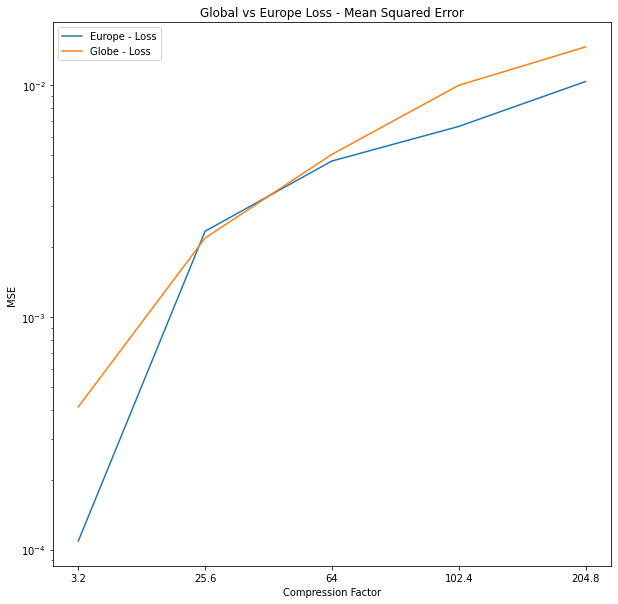

In [2]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,loss_eur , label = "Europe - Loss")
plt.plot(x,loss_glob , label = "Globe - Loss")
plt.yscale('log')
plt.title('Global vs Europe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

## R2 - Global vs Europe

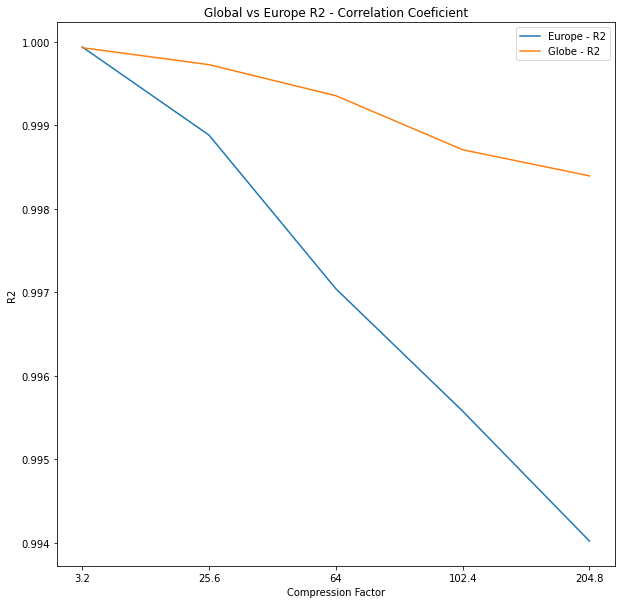

In [3]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , label = "Europe - R2")
plt.plot(x,r2_glob , label = "Globe - R2")
#plt.yscale('log')
plt.title('Global vs Europe R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

## MAE - Global vs Europe

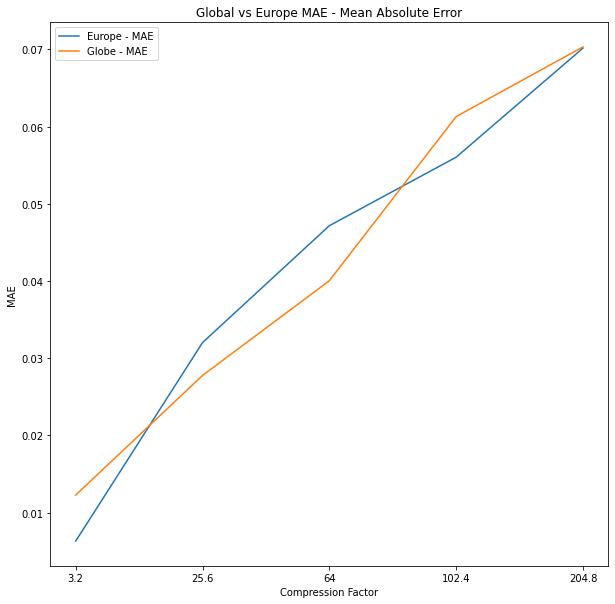

In [4]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Europe - MAE")
plt.plot(x,mae_glob , label = "Globe - MAE")
#plt.yscale('log')
plt.title('Global vs Europe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Evaluating Loss, R2, MAE - 1979 vs 1980 only in Europe

In [5]:
import xarray as xr
import tensorflow as tf
from collections import OrderedDict
from lossycomp.models import Autoencoder
from tensorflow.keras.optimizers import Adam
from lossycomp.plots import mult_plot, single_plot, plot_history
from lossycomp.utils import check_gpu, decay_schedule, r2_coef
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data

file = '/lsdf/kit/scc/projects/abcde/1979/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=40, latitude=40, level=1)

model_name = 'model_7'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

dg_val_europe = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


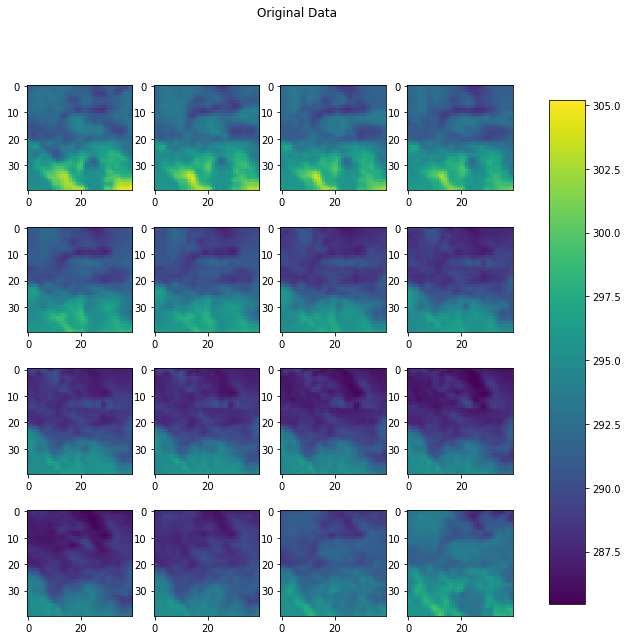

In [14]:
from lossycomp.plots import mult_plot, single_plot, plot_history
import numpy as np
test_n = norm_data(dg_val_europe.__getitem__(0)[0][1], mean, std)
test_n = np.expand_dims(test_n, axis=0)
mult_plot(test_n, 4, 4, "Original Data", test_n.min(), test_n.max())

In [8]:
print(dg_val_europe.__getitem__(90)[0][1].shape)
print(dg_val_europe.info(90)[1])

(16, 40, 40, 1)
{'longitude': slice(95, 135, None), 'latitude': slice(59, 99, None), 'level': slice(0, 1, None), 'time': slice(5270, 5286, None)}


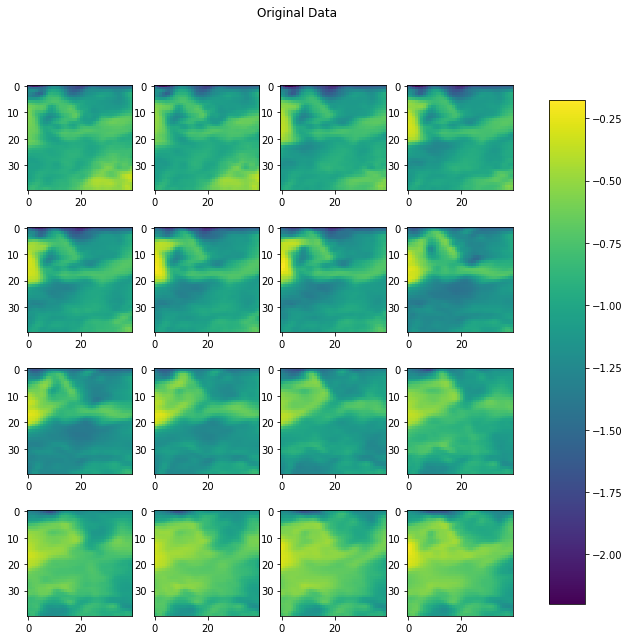

In [7]:
aa = dg_val_europe.data.isel(longitude= slice(95, 135),
 latitude =  slice(59, 99),
 level=  slice(0,1),
 time =slice(5270, 5286))

test_data = np.expand_dims(aa, axis=0)

mult_plot(test_data, 4, 4, "Original Data", test_data.min(), test_data.max())

In [6]:
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 39s 39ms/step - loss: 1.0026e-04 - r2_coef: 0.9999 - MAE: 0.0061


In [7]:
res

[0.00010025893425336108, 0.999938428401947, 0.00609591044485569]

In [8]:
model_name = 'model_10'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 39s 39ms/step - loss: 0.0021 - r2_coef: 0.9987 - MAE: 0.0303


In [9]:
res

[0.002119653392583132, 0.9986813068389893, 0.03029491938650608]

In [10]:
model_name = 'model_6'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe)

1000/1000 [==============================] - 38s 38ms/step - loss: 0.0046 - r2_coef: 0.9972 - MAE: 0.0450


In [11]:
res

[0.004556597676128149, 0.9971935749053955, 0.04502406716346741]

In [12]:
file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "europe"
var = OrderedDict({'t': 1000})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_val_europe_48 = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [13]:
model_name = 'model_5'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 40], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe_48)

1000/1000 [==============================] - 44s 44ms/step - loss: 0.0062 - r2_coef: 0.9961 - MAE: 0.0537


In [14]:
res

[0.006232471205294132, 0.9960570931434631, 0.05367785319685936]

In [15]:
model_name = 'model_4'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 20], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_europe_48)

1000/1000 [==============================] - 46s 46ms/step - loss: 0.0097 - r2_coef: 0.9939 - MAE: 0.0678


In [16]:
res

[0.009723539464175701, 0.9938862323760986, 0.0678497850894928]

In [17]:
losses_eur_val = [0.00010036735329777002, 0.0021272955927997828, 0.004528641235083342, 0.006245248019695282, 0.009771274402737617]
r2s_eur_val = [0.9999386072158813, 0.998690128326416, 0.997221827507019, 0.9960830211639404, 0.993820309638977]
maes_eur_val = [0.006093519274145365, 0.030291225761175156, 0.04488058015704155, 0.05375417694449425, 0.06801731139421463]

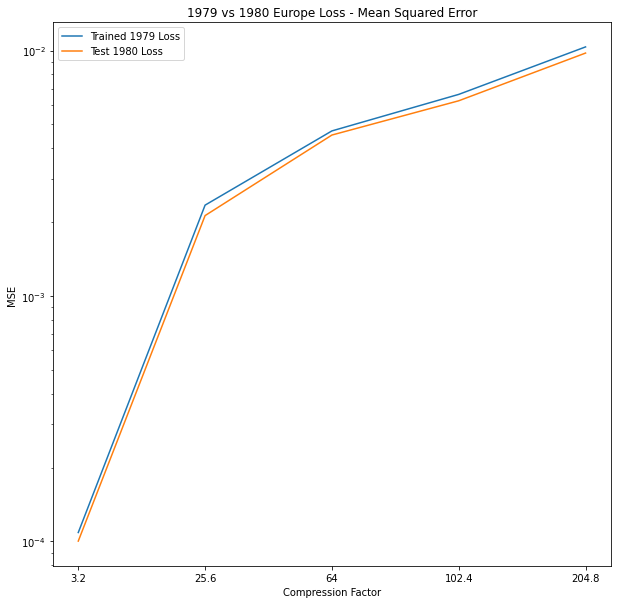

In [18]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, loss_eur, label = "Trained 1979 Loss")
plt.plot(x, losses_eur_val , label = "Test 1980 Loss")
plt.yscale('log')
plt.title('1979 vs 1980 Europe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

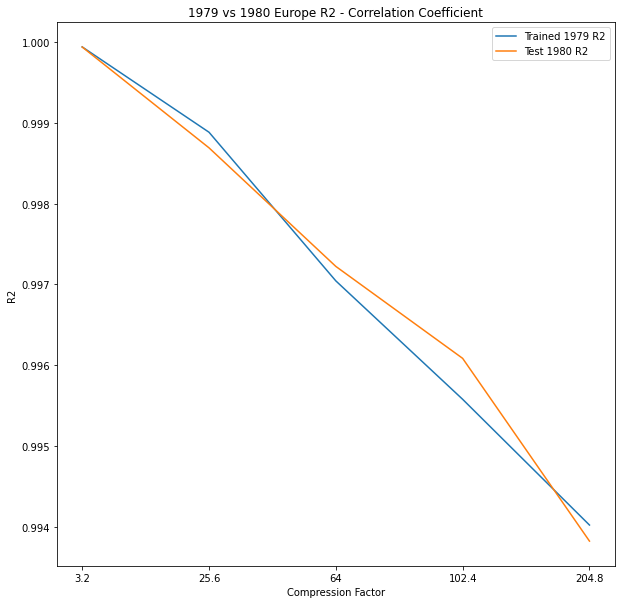

In [19]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2_eur, label = "Trained 1979 R2")
plt.plot(x, r2s_eur_val , label = "Test 1980 R2")
#plt.yscale('log')
plt.title('1979 vs 1980 Europe R2 - Correlation Coefficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

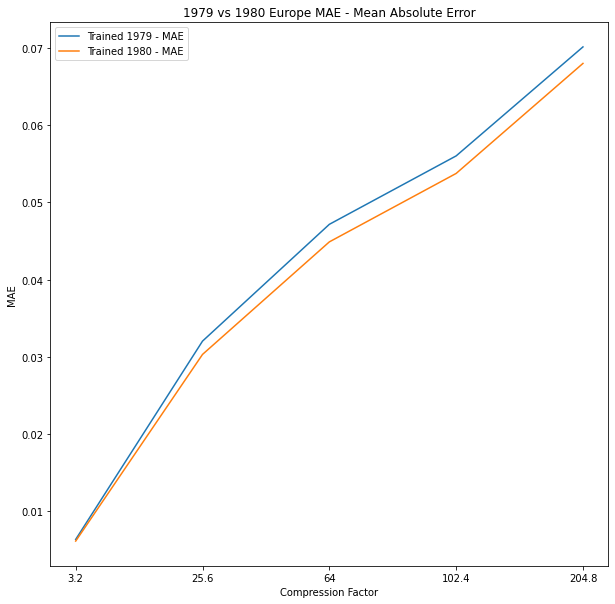

In [20]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Trained 1979 - MAE")
plt.plot(x, maes_eur_val , label = "Trained 1980 - MAE")
plt.title('1979 vs 1980 Europe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Evaluating Loss, R2, MAE - 1980 SAHARA

In [207]:
import xarray as xr
import tensorflow as tf
from collections import OrderedDict
from lossycomp.models import Autoencoder
from tensorflow.keras.optimizers import Adam
from lossycomp.plots import mult_plot, single_plot, plot_history
from lossycomp.utils import check_gpu, decay_schedule, r2_coef
from lossycomp.dataLoader import DataGenerator, data_preprocessing, split_data, norm_data

model_name = 'model_8'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "globe"
var = OrderedDict({'t': 100})

import dask

dask.config.set(**{'array.slicing.split_large_chunks': False})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=40, latitude=40, level=1)

dg_val_globe = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [208]:
model_name = 'model_8'

from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 45s 45ms/step - loss: 0.0187 - r2_coef: 0.9959 - MAE: 0.1240


In [209]:
res

[0.01873556338250637, 0.9959399700164795, 0.12402446568012238]

In [210]:
model_name = 'model_9'

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 62s 62ms/step - loss: 0.0021 - r2_coef: 0.9996 - MAE: 0.0322


In [211]:
res

[0.0020512647461146116, 0.999556303024292, 0.032178815454244614]

In [212]:
model_name = 'model_11'

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 43s 43ms/step - loss: 0.2301 - r2_coef: 0.9501 - MAE: 0.3757


In [213]:
res

[0.2301357388496399, 0.9501491785049438, 0.37566572427749634]

In [214]:
model_name = 'model_12'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

file = '/lsdf/kit/scc/projects/abcde/1980/*/ERA5.pl.temperature.nc'
region = "globe"
var = OrderedDict({'t': 100})

import dask

dask.config.set(**{'array.slicing.split_large_chunks': False})

z, mean1, std1 = data_preprocessing(file, var, region)

train, test = split_data(z, 0.70)

leads = dict(time = 16, longitude=48, latitude=48, level=1)

dg_val_globe_48 = DataGenerator(train, 100000, leads, batch_size=100, load=True, mean= mean, std=std) 

Loading data into RAM


In [215]:
from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model)  = Autoencoder.build(16, 48, 48, 1, filters = (10, 20, 20,20))
model_name = 'model_12'
# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 51s 51ms/step - loss: 0.0076 - r2_coef: 0.9983 - MAE: 0.0648


In [216]:
res

[0.007647727616131306, 0.9983241558074951, 0.06482250988483429]

In [217]:
model_name = 'model_13'
    
# Load model architecture.
(encoder, decoder, model) =  Autoencoder.build(16, 48, 48, 1, filters = (10,20,20,40))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 52s 52ms/step - loss: 1.7490 - r2_coef: 0.6179 - MAE: 0.9615


In [218]:
res

[1.748957633972168, 0.6179064512252808, 0.961524486541748]

In [1]:
losses_sahara = [0.00044622630230151117, 0.004932433366775513, 0.009640829637646675, 0.019470801576972008, 0.019921274855732918, ] 
r2s_sahara = [ 0.9997758269309998, 0.9975407123565674, 0.9951958060264587,  0.9902764558792114, 0.9900861382484436,]
maes_sahara = [0.01354655809700489, 0.0490486733615398, 0.06937922537326813,  0.10151907056570053, 0.10304386913776398]

losses_polar = [0.0018630060367286205, 0.0016057011671364307, 0.0036538306158035994, 0.009243261069059372, 0.009554588235914707]
r2s_polar = [0.9995002150535583, 0.999569296836853, 0.9990172386169434, 0.9974995255470276, 0.9974313974380493]
maes_polar = [0.03460095450282097, 0.02384255640208721, 0.037692438811063766,  0.06002272665500641,  0.06153511255979538]

losses_tibet = [0.001002271892502904, 0.007754565216600895, 0.014376470819115639,0.03171420469880104, 0.033030133694410324] 
r2s_tibet = [0.9988904595375061, 0.9914165735244751, 0.9841160178184509,0.9722241163253784, 0.9712088108062744,]
maes_tibet = [ 0.017952721565961838, 0.0512838177382946, 0.06951218843460083, 0.11168764531612396, 0.1131533607840538]

losses_subtropical = [0.0005676968139596283,0.004839054774492979, 0.009277843870222569, 0.018039125949144363, 0.019198749214410782]
r2s_subtropical = [0.9996463060379028, 0.9969844818115234, 0.994224488735199, 0.988949716091156, 0.9882616996765137]
maes_subtropical = [0.013144743628799915, 0.04004133865237236, 0.05560905113816261, 0.08177470415830612, 0.0836956650018692]

losses_temperate = [0.0008333799778483808, 0.003107558935880661, 0.006851231679320335, 0.014826294034719467, 0.016095886006951332]
r2s_temperate = [0.9998005628585815, 0.9992421865463257, 0.9983201622962952,0.9963747262954712,0.9960716366767883,]
maes_temperate = [0.01880190707743168, 0.0351078025996685, 0.052572187036275864,  0.07965531200170517, 0.08304185420274734]

losses_tropical = [0.00033237761817872524, 0.0025155299808830023, 0.004510890692472458,0.008044217713177204, 0.008517833426594734]
r2s_tropical = [0.9987519979476929, 0.990484356880188, 0.9828684329986572, 0.9685953259468079, 0.9667891263961792]
maes_tropical = [ 0.010731443762779236, 0.02966500259935856, 0.039962705224752426, 0.05703902244567871, 0.05771730840206146]

losses_greenland = [0.0008392025483772159, 0.002310625510290265, 0.005631649866700172,0.013541578315198421,0.015025452710688114 ]
r2s_greenland = [0.9995849132537842, 0.9988605380058289, 0.9972057342529297,0.9933425188064575,0.992630124092102]
maes_greenland = [0.02157728560268879, 0.031338006258010864, 0.04966583475470543, 0.07919766753911972, 0.08343315124511719]

In [205]:
losses_press_1 = [0.0019656384829431772,0.007512897253036499, 0.0218821968883276,0.03751746565103531,0.04349133372306824]
r2s_press_1 = [ 0.9995291233062744,0.9981777667999268, 0.9947214126586914, 0.9906726479530334, 0.9890733361244202 ]
maes_press_1 = [0.034597381949424744, 0.06189263239502907,0.1065426841378212, 0.1437041163444519, 0.1532289683818817 ]

losses_press_7 = [0.008954072371125221,0.004272594582289457,0.0420057512819767,0.02057722397148609,0.2214304655790329]
r2s_press_7 = [ 0.9980624318122864,0.9990583062171936,0.9910656809806824,0.9953824281692505, 0.952115535736084]
maes_press_7 = [0.08395171165466309, 0.047462690621614456, 0.1332409381866455, 0.10801620036363602, 0.24531058967113495]

losses_press_100 = [0.018709946423768997, 0.0020466933492571115, 0.22981500625610352 ,0.007653154898434877, 1.7588963508605957]
r2s_press_100 = [0.9959516525268555, 0.9995571970939636, 0.9501683115959167, 0.9983198642730713,0.615356981754303]
maes_press_100 = [0.12393533438444138, 0.03211219236254692, 0.37536442279815674, 0.06482783704996109, 0.9650611281394958]

losses_press_200 = [0.01376421470195055, 0.0012042702874168754, 0.05384388193488121,0.005258501507341862,0.31933942437171936 ]  
r2s_press_200 = [0.9896914958953857, 0.999099850654602,0.9607306718826294,0.99599689245224,0.7602534890174866]
maes_press_200 = [ 0.1072608008980751, 0.023727288469672203, 0.1722698211669922, 0.052589986473321915, 0.36215823888778687]

losses_press_500 = [0.003170495852828026,0.0006495676934719086,0.0019433589186519384,0.0031566384714096785,0.004116241820156574]
r2s_press_500 = [0.9992969632148743,0.9998562335968018,0.9995682239532471,0.9992870688438416,  0.9990774393081665]
maes_press_500 = [ 0.047001298516988754, 0.016807377338409424,  0.029397986829280853,0.038761720061302185, 0.04308600351214409]

losses_press_1000 = [0.0007685561431571841, 0.0024373438209295273, 0.005060350522398949, 0.010558254085481167, 0.011284969747066498,]
r2s_press_1000 = [0.9998912811279297, 0.9996751546859741, 0.9993270039558411, 0.9985651969909668,0.9984702467918396,]
maes_press_1000 = [0.01756349951028824, 0.028786074370145798, 0.042095426470041275, 0.06320030987262726, 0.06509505957365036]

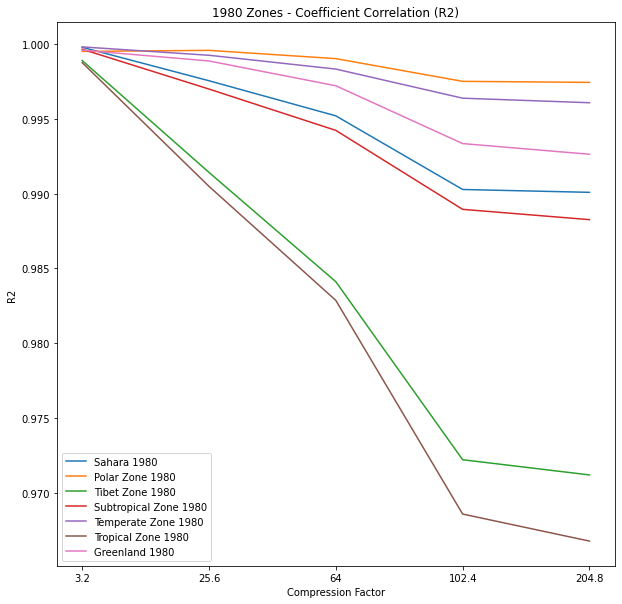

In [113]:
import matplotlib.pyplot as plt
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2s_sahara, label = "Sahara 1980")
plt.plot(x, r2s_polar, label = "Polar Zone 1980")
plt.plot(x, r2s_tibet, label = "Tibet Zone 1980")
plt.plot(x, r2s_subtropical, label = "Subtropical Zone 1980")
plt.plot(x, r2s_temperate, label = "Temperate Zone 1980")
plt.plot(x, r2s_tropical, label = "Tropical Zone 1980")
plt.plot(x, r2s_greenland, label = "Greenland 1980")


#plt.yscale('log')
plt.title('1980 Zones - Coefficient Correlation (R2)')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

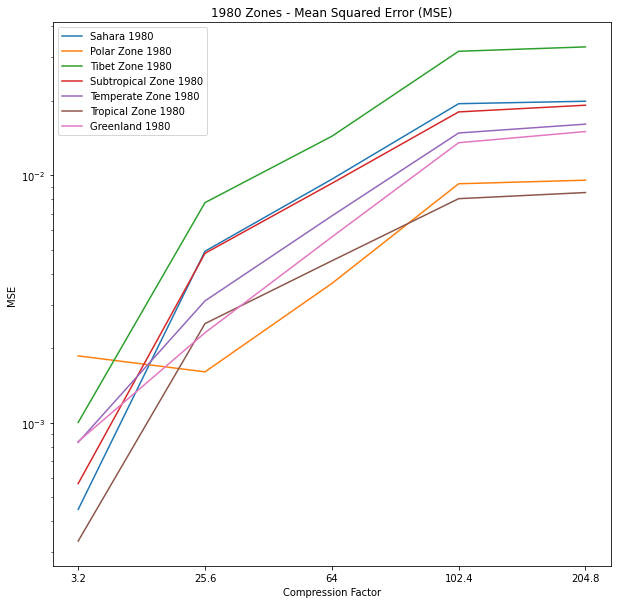

In [223]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, losses_sahara, label = "Sahara 1980")
plt.plot(x, losses_polar, label = "Polar Zone 1980")
plt.plot(x, losses_tibet, label = "Tibet Zone 1980")
plt.plot(x, losses_subtropical, label = "Subtropical Zone 1980")
plt.plot(x, losses_temperate, label = "Temperate Zone 1980")
plt.plot(x, losses_tropical, label = "Tropical Zone 1980")
plt.plot(x, losses_greenland, label = "Greenland 1980")


plt.yscale('log')
plt.title('1980 Zones - Mean Squared Error (MSE)')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

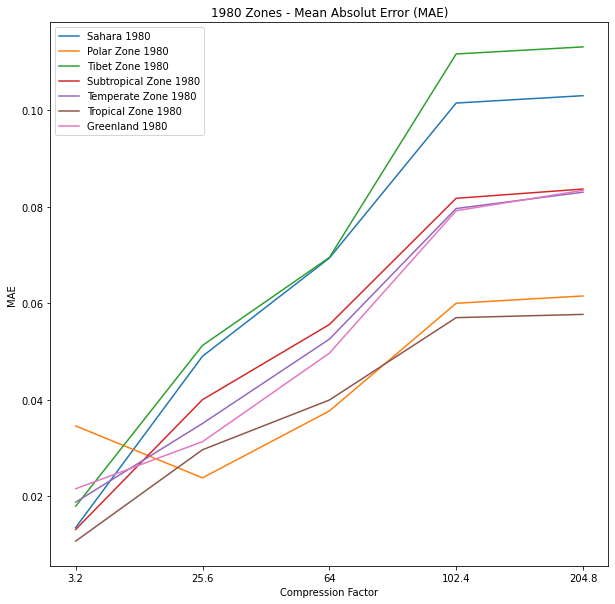

In [220]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, maes_sahara, label = "Sahara 1980")
plt.plot(x, maes_polar, label = "Polar Zone 1980")
plt.plot(x, maes_tibet, label = "Tibet Zone 1980")
plt.plot(x, maes_subtropical, label = "Subtropical Zone 1980")
plt.plot(x, maes_temperate, label = "Temperate Zone 1980")
plt.plot(x, maes_tropical, label = "Tropical Zone 1980")
plt.plot(x, maes_greenland, label = "Greenland 1980")


#plt.yscale('log')
plt.title('1980 Zones - Mean Absolut Error (MAE)')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

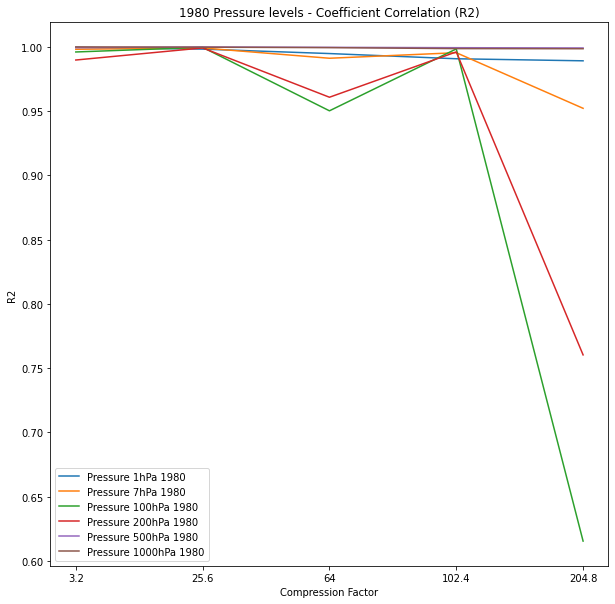

In [206]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2s_press_1 , label = "Pressure 1hPa 1980")
plt.plot(x, r2s_press_7 , label = "Pressure 7hPa 1980")
plt.plot(x, r2s_press_100 , label = "Pressure 100hPa 1980")
plt.plot(x, r2s_press_200 , label = "Pressure 200hPa 1980")
plt.plot(x, r2s_press_500 , label = "Pressure 500hPa 1980")
plt.plot(x, r2s_press_1000 , label = "Pressure 1000hPa 1980")
 

#plt.yscale('log')
plt.title('1980 Pressure levels - Coefficient Correlation (R2)')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

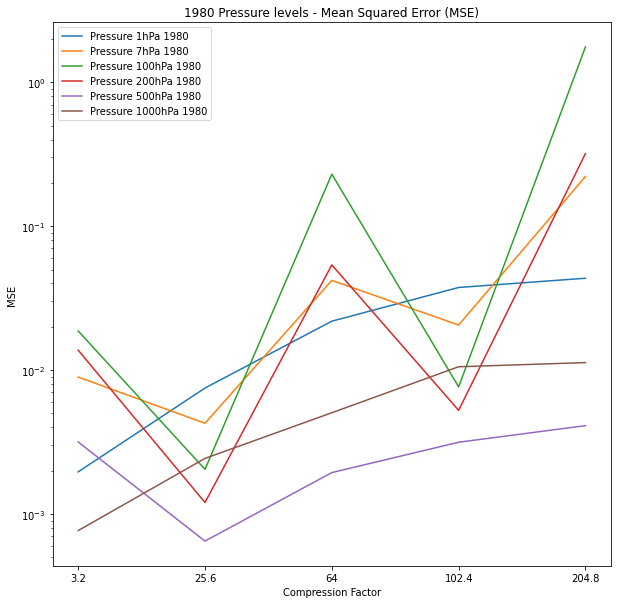

In [222]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, losses_press_1 , label = "Pressure 1hPa 1980")
plt.plot(x, losses_press_7 , label = "Pressure 7hPa 1980")
plt.plot(x, losses_press_100 , label = "Pressure 100hPa 1980")
plt.plot(x, losses_press_200 , label = "Pressure 200hPa 1980")
plt.plot(x, losses_press_500 , label = "Pressure 500hPa 1980")
plt.plot(x, losses_press_1000 , label = "Pressure 1000hPa 1980")
 

plt.yscale('log')
plt.title('1980 Pressure levels - Mean Squared Error (MSE)')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

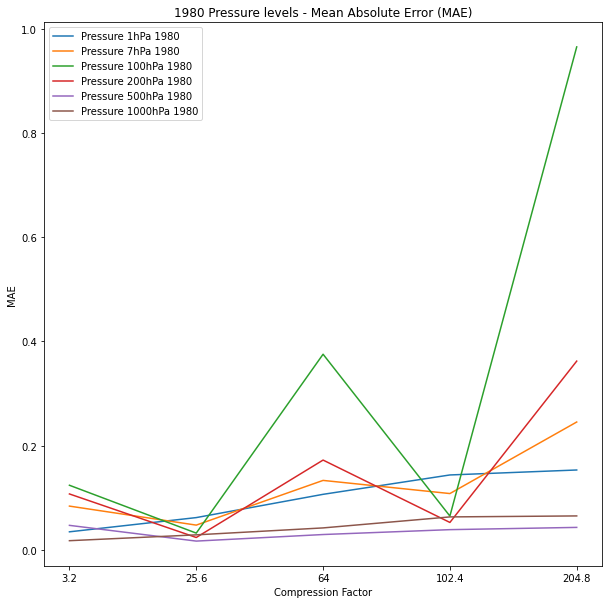

In [225]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, maes_press_1 , label = "Pressure 1hPa 1980")
plt.plot(x, maes_press_7 , label = "Pressure 7hPa 1980")
plt.plot(x, maes_press_100 , label = "Pressure 100hPa 1980")
plt.plot(x, maes_press_200 , label = "Pressure 200hPa 1980")
plt.plot(x, maes_press_500 , label = "Pressure 500hPa 1980")
plt.plot(x, maes_press_1000 , label = "Pressure 1000hPa 1980")
 

#plt.yscale('log')
plt.title('1980 Pressure levels - Mean Absolute Error (MAE)')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

## Trained in europe, tested over the globe.

In [37]:
model_name = 'model_7'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.models import Autoencoder
# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 47s 47ms/step - loss: 1.7066e-04 - r2_coef: 1.0000 - MAE: 0.0067


In [38]:
res

[0.0001706635084701702, 0.9999819397926331, 0.006709206849336624]

In [39]:
model_name = 'model_10'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (10, 20, 20))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 42s 42ms/step - loss: 0.0022 - r2_coef: 0.9997 - MAE: 0.0275


In [40]:
res

[0.0021568152587860823, 0.9996837377548218, 0.02746403217315674]

In [41]:
model_name = 'model_6'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

# Load model architecture.
(encoder, decoder, model) = Autoencoder.build(16, 40, 40, 1, filters = (32, 16, 8))

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe)

1000/1000 [==============================] - 40s 40ms/step - loss: 0.0069 - r2_coef: 0.9990 - MAE: 0.0446


In [42]:
res

[0.006945624947547913, 0.9989863038063049, 0.04463711380958557]

In [43]:
model_name = 'model_5'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 40], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

1000/1000 [==============================] - 51s 51ms/step - loss: 0.0069 - r2_coef: 0.9991 - MAE: 0.0504


In [44]:
res

[0.0068815783597528934, 0.9990654587745667, 0.05040992796421051]

In [2]:
model_name = 'model_4'

with open('../results/'+ model_name +'/model-history.pkl', 'rb') as f:
    data = pickle.load(f)
    mean = data['mean']
    std =  data['std']

from lossycomp.utils import Autoencoder
# Load model architecture.
model = Autoencoder((16, 48, 48, 1), [10, 20, 20, 20], [4, 4, 4, 4], [2, 2, 2, 2])

# Load weights.
model.load_weights('../results/'+model_name+'/weights/params_model_epoch_199.hdf5')

model.compile(optimizer = Adam(lr=0.001), loss=tf.keras.losses.MeanSquaredError(), metrics=[r2_coef, 'MAE'])

res = model.evaluate(dg_val_globe_48)

NameError: name 'pickle' is not defined

In [46]:
res

[0.010457174852490425, 0.9985857009887695, 0.06260299682617188]

In [47]:
losses_eur_glob_val = [0.00017146677419077605,0.0021514890249818563,0.006753660272806883, 0.006883593741804361,0.01061693113297224 ]
r2s_eur_glob_val = [0.9999818801879883,0.9996828436851501,0.9990004897117615,0.9990699291229248,0.9985544681549072]
maes_eur_glob_val = [0.006718733813613653,  0.0274074524641037, 0.04417809471487999, 0.05051010474562645, 0.06301198899745941]

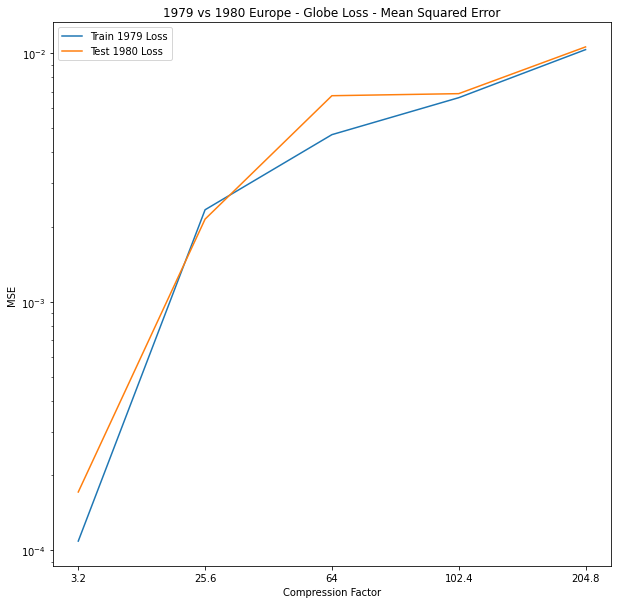

In [48]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, loss_eur, label = "Train 1979 Loss")
plt.plot(x, losses_eur_glob_val , label = "Test 1980 Loss")
plt.yscale('log')
plt.title('1979 vs 1980 Europe - Globe Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

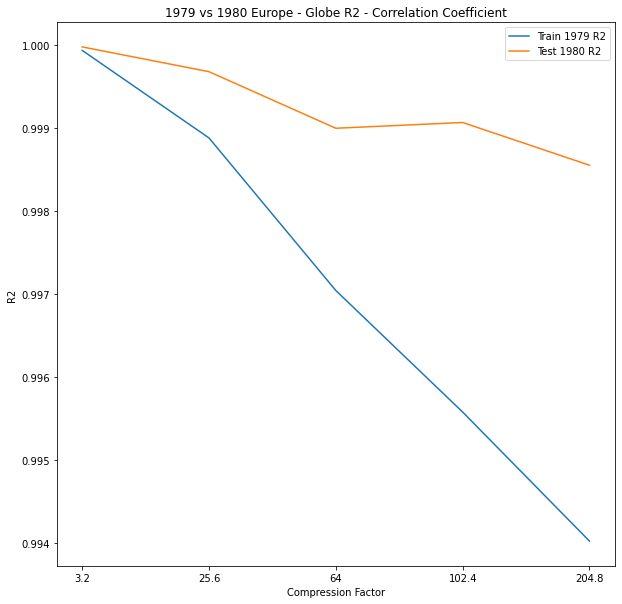

In [49]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x, r2_eur, label = "Train 1979 R2")
plt.plot(x, r2s_eur_glob_val , label = "Test 1980 R2")
plt.title('1979 vs 1980 Europe - Globe R2 - Correlation Coefficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

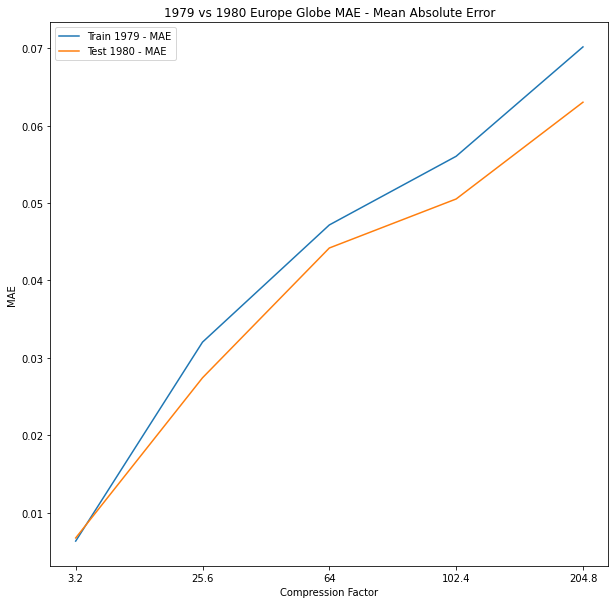

In [50]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , label = "Train 1979 - MAE")
plt.plot(x, maes_eur_glob_val , label = "Test 1980 - MAE")
plt.title('1979 vs 1980 Europe Globe MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()

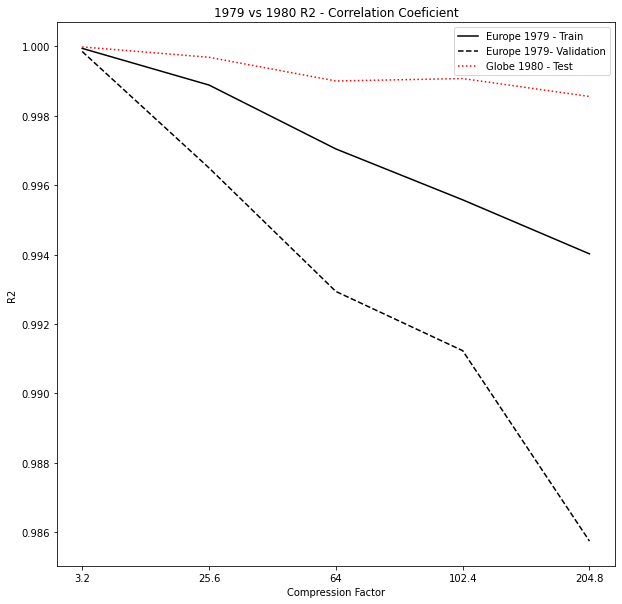

In [54]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x, r2_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, r2s_eur_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, r2s_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

## Plotting everything together

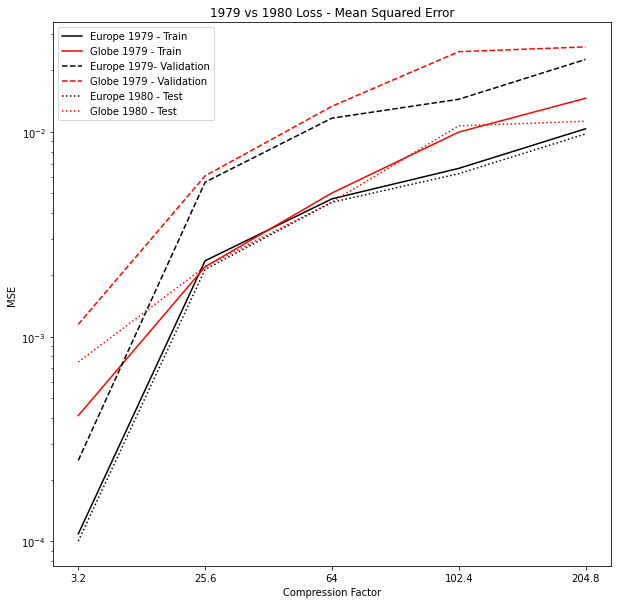

In [51]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,loss_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,loss_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, loss_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, loss_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, losses_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, losses_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, losses_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
plt.yscale('log')
plt.title('1979 vs 1980 Loss - Mean Squared Error')
plt.xlabel('Compression Factor')
plt.ylabel('MSE')
plt.legend()
plt.show()

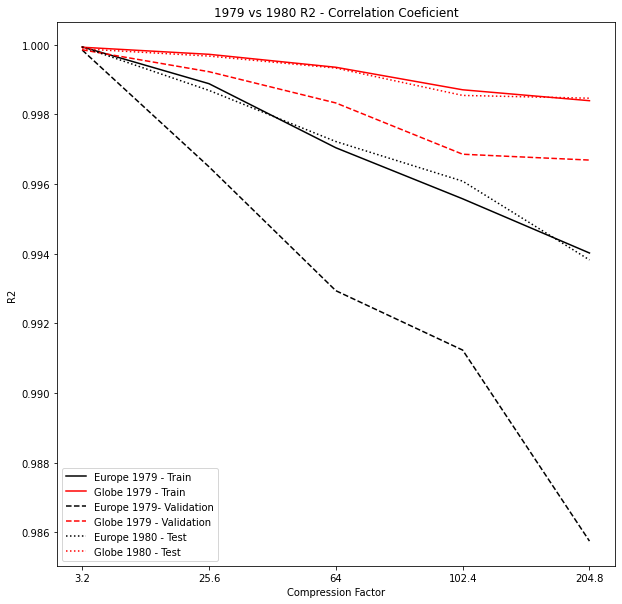

In [52]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,r2_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,r2_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, r2_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, r2_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, r2s_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, r2s_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, r2s_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 R2 - Correlation Coeficient')
plt.xlabel('Compression Factor')
plt.ylabel('R2')
plt.legend()
plt.show()

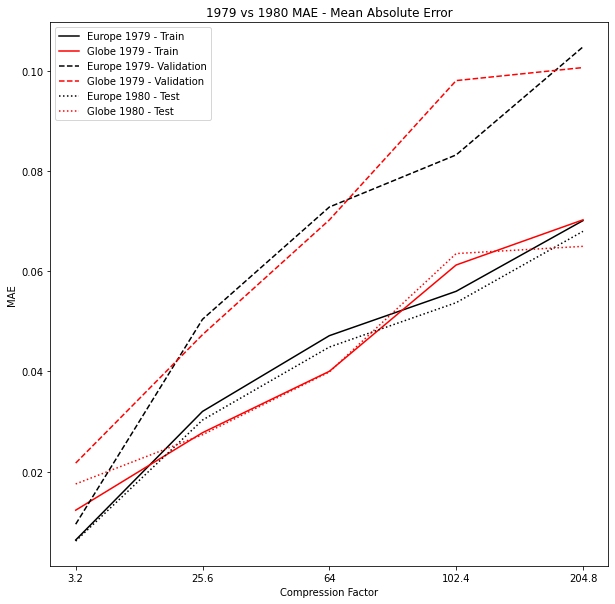

In [53]:
plt.figure(figsize=(10,10)) 
x = ['3.2', '25.6', '64' ,'102.4', '204.8' ]
plt.plot(x,mae_eur , 'k-',label = "Europe 1979 - Train")
plt.plot(x,mae_glob , 'r-', label = "Globe 1979 - Train")
plt.plot(x, mae_eur_test , 'k--',label = "Europe 1979- Validation")
plt.plot(x, mae_glob_test , 'r--',label = "Globe 1979 - Validation")
plt.plot(x, maes_eur_val , 'k:',label = "Europe 1980 - Test")
plt.plot(x, maes_glob_val , 'r:',label = "Globe 1980 - Test")
#plt.plot(x, maes_eur_glob_val ,'r', label = "Europe 1979 - Train, 1980 Globe - Test")
#plt.yscale('log')
plt.title('1979 vs 1980 MAE - Mean Absolute Error')
plt.xlabel('Compression Factor')
plt.ylabel('MAE')
plt.legend()
plt.show()